In [1]:
# general
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.sparse import dok_matrix

# plots
import matplotlib.pyplot as plt

# sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

## Solution 2: Classifying spam

### a)

The spam data has a binary classification problem, where the aim is to classify an e-mail as spam or non-spam, saved in variable "type".

In [2]:
# | label: 2-a-1
data_spam = pd.read_csv("../data/spam.csv")
data_spam.drop(data_spam.columns[[0]], axis=1, inplace=True)

X_spam = data_spam.copy()  # note without copy() X_spam is not a variable but a pointer
y_spam = X_spam.pop("type")

print(y_spam.value_counts())

type
nonspam    2788
spam       1813
Name: count, dtype: int64


In [19]:
# | label: 2-a-2
print(X_spam.describe().head())

           address    addresses          all     business   capitalAve  \
count  4601.000000  4601.000000  4601.000000  4601.000000  4601.000000   
mean      0.213015     0.049205     0.280656     0.142586     5.191515   
std       1.290575     0.258843     0.504143     0.444055    31.729449   
min       0.000000     0.000000     0.000000     0.000000     1.000000   
25%       0.000000     0.000000     0.000000     0.000000     1.588000   

       capitalLong  capitalTotal   charDollar  charExclamation     charHash  \
count  4601.000000   4601.000000  4601.000000      4601.000000  4601.000000   
mean     52.172789    283.289285     0.075811         0.269071     0.044238   
std     194.891310    606.347851     0.245882         0.815672     0.429342   
min       1.000000      1.000000     0.000000         0.000000     0.000000   
25%       6.000000     35.000000     0.000000         0.000000     0.000000   

       ...           re      receive       remove       report        table  \
c

### b)

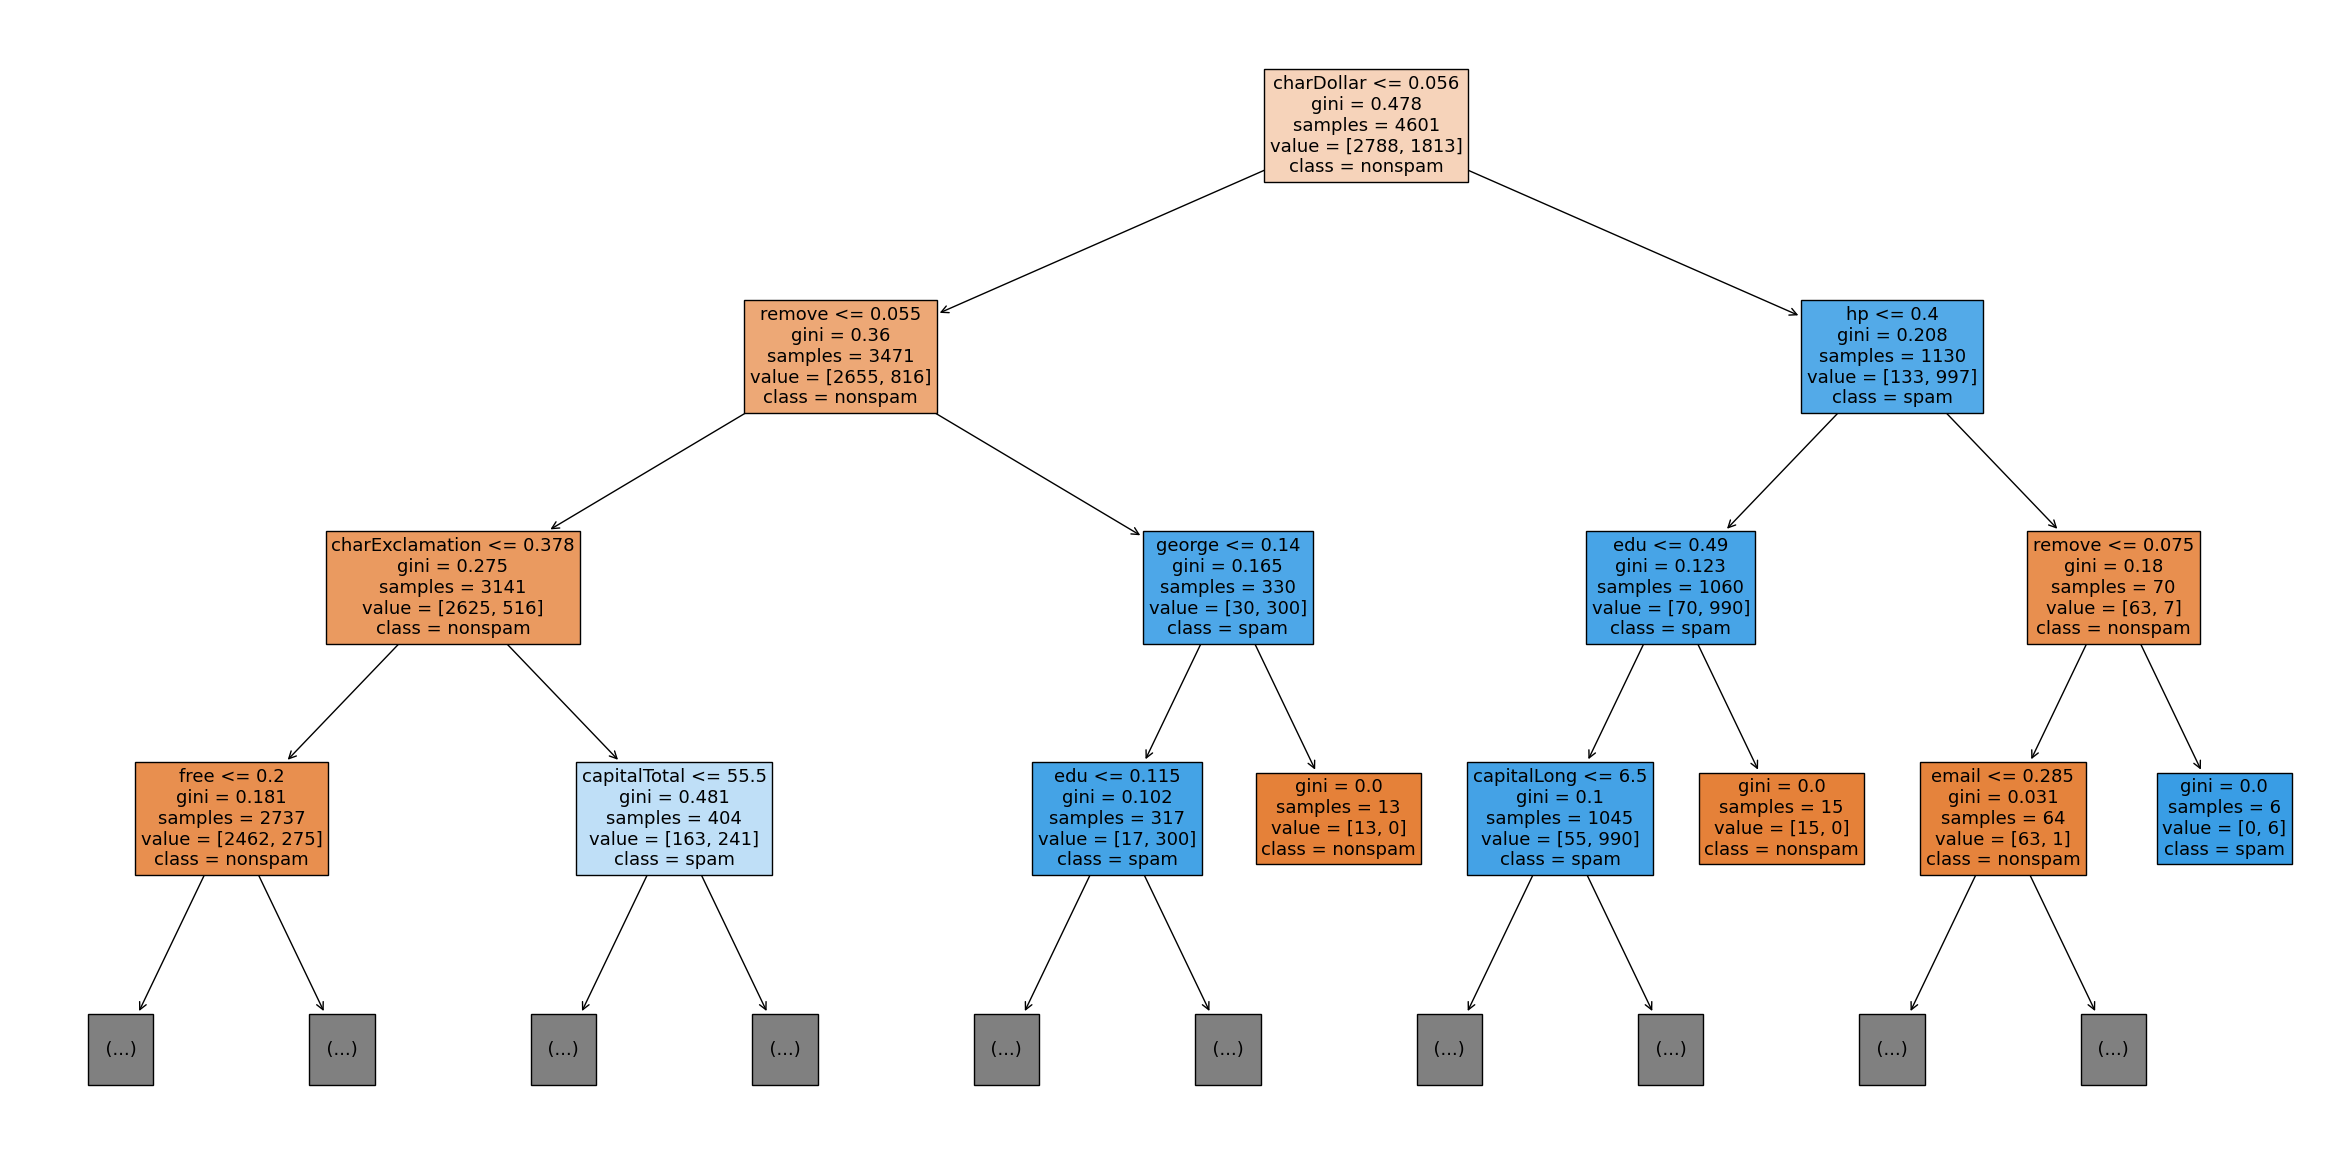

In [3]:
# | label: 2-b-1
# train on full data set
random_state = 43
tree_class_full = DecisionTreeClassifier()
tree_class_full.fit(X_spam, y_spam)
class_names = data_spam.type.unique().tolist()
class_names.sort()
# use plot_tree to visualize the decision tree
plt.figure(figsize=(30, 15))
plot_tree(
    tree_class_full,
    max_depth=3,
    feature_names=X_spam.columns,
    class_names=class_names,
    filled=True,
    fontsize=13,
)
plt.show()

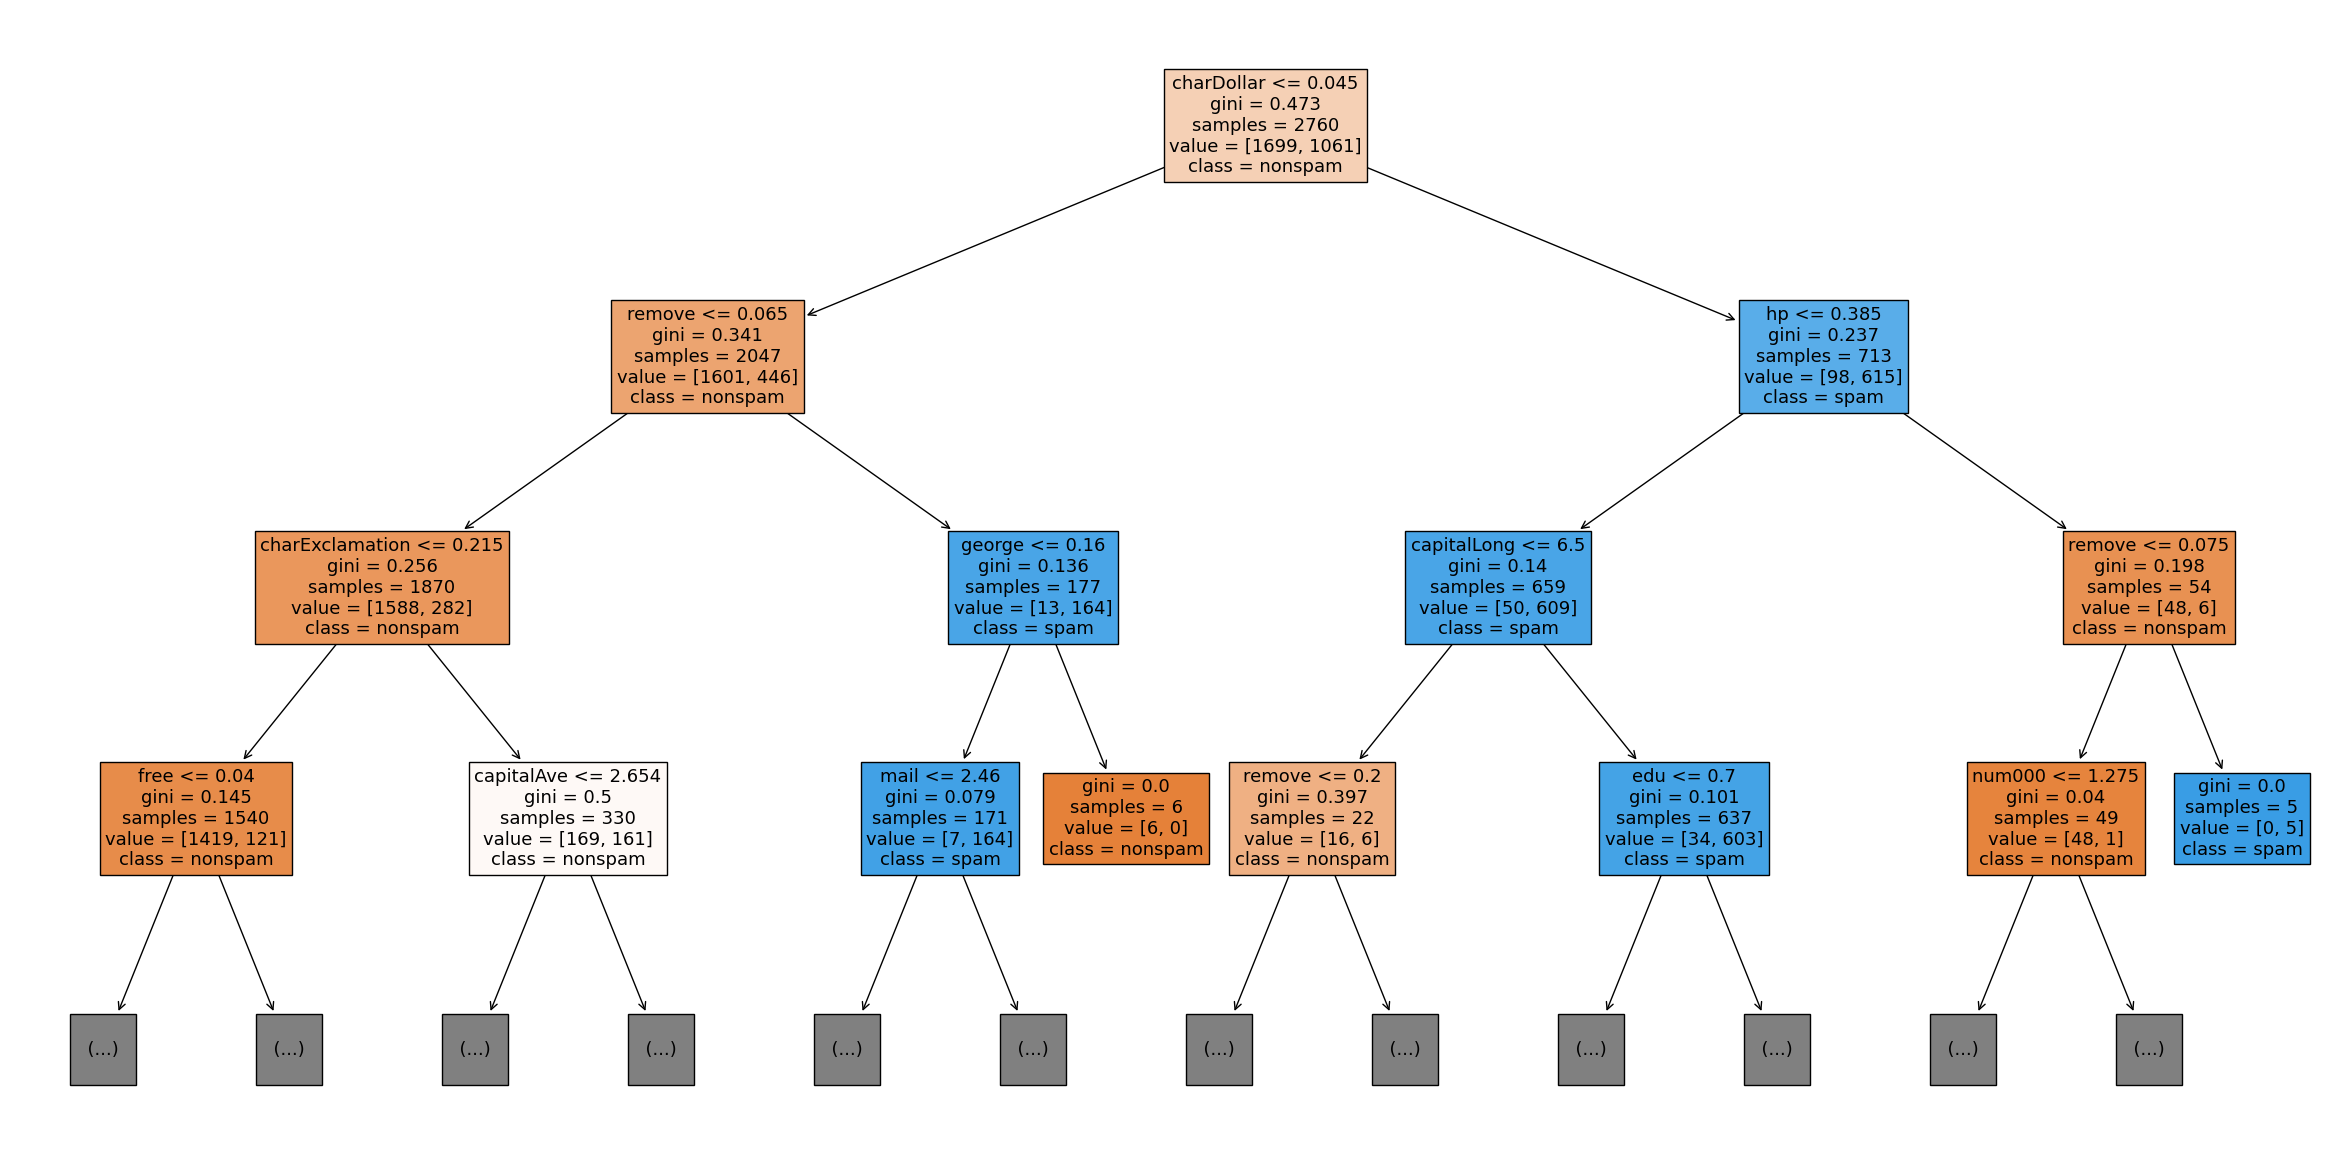

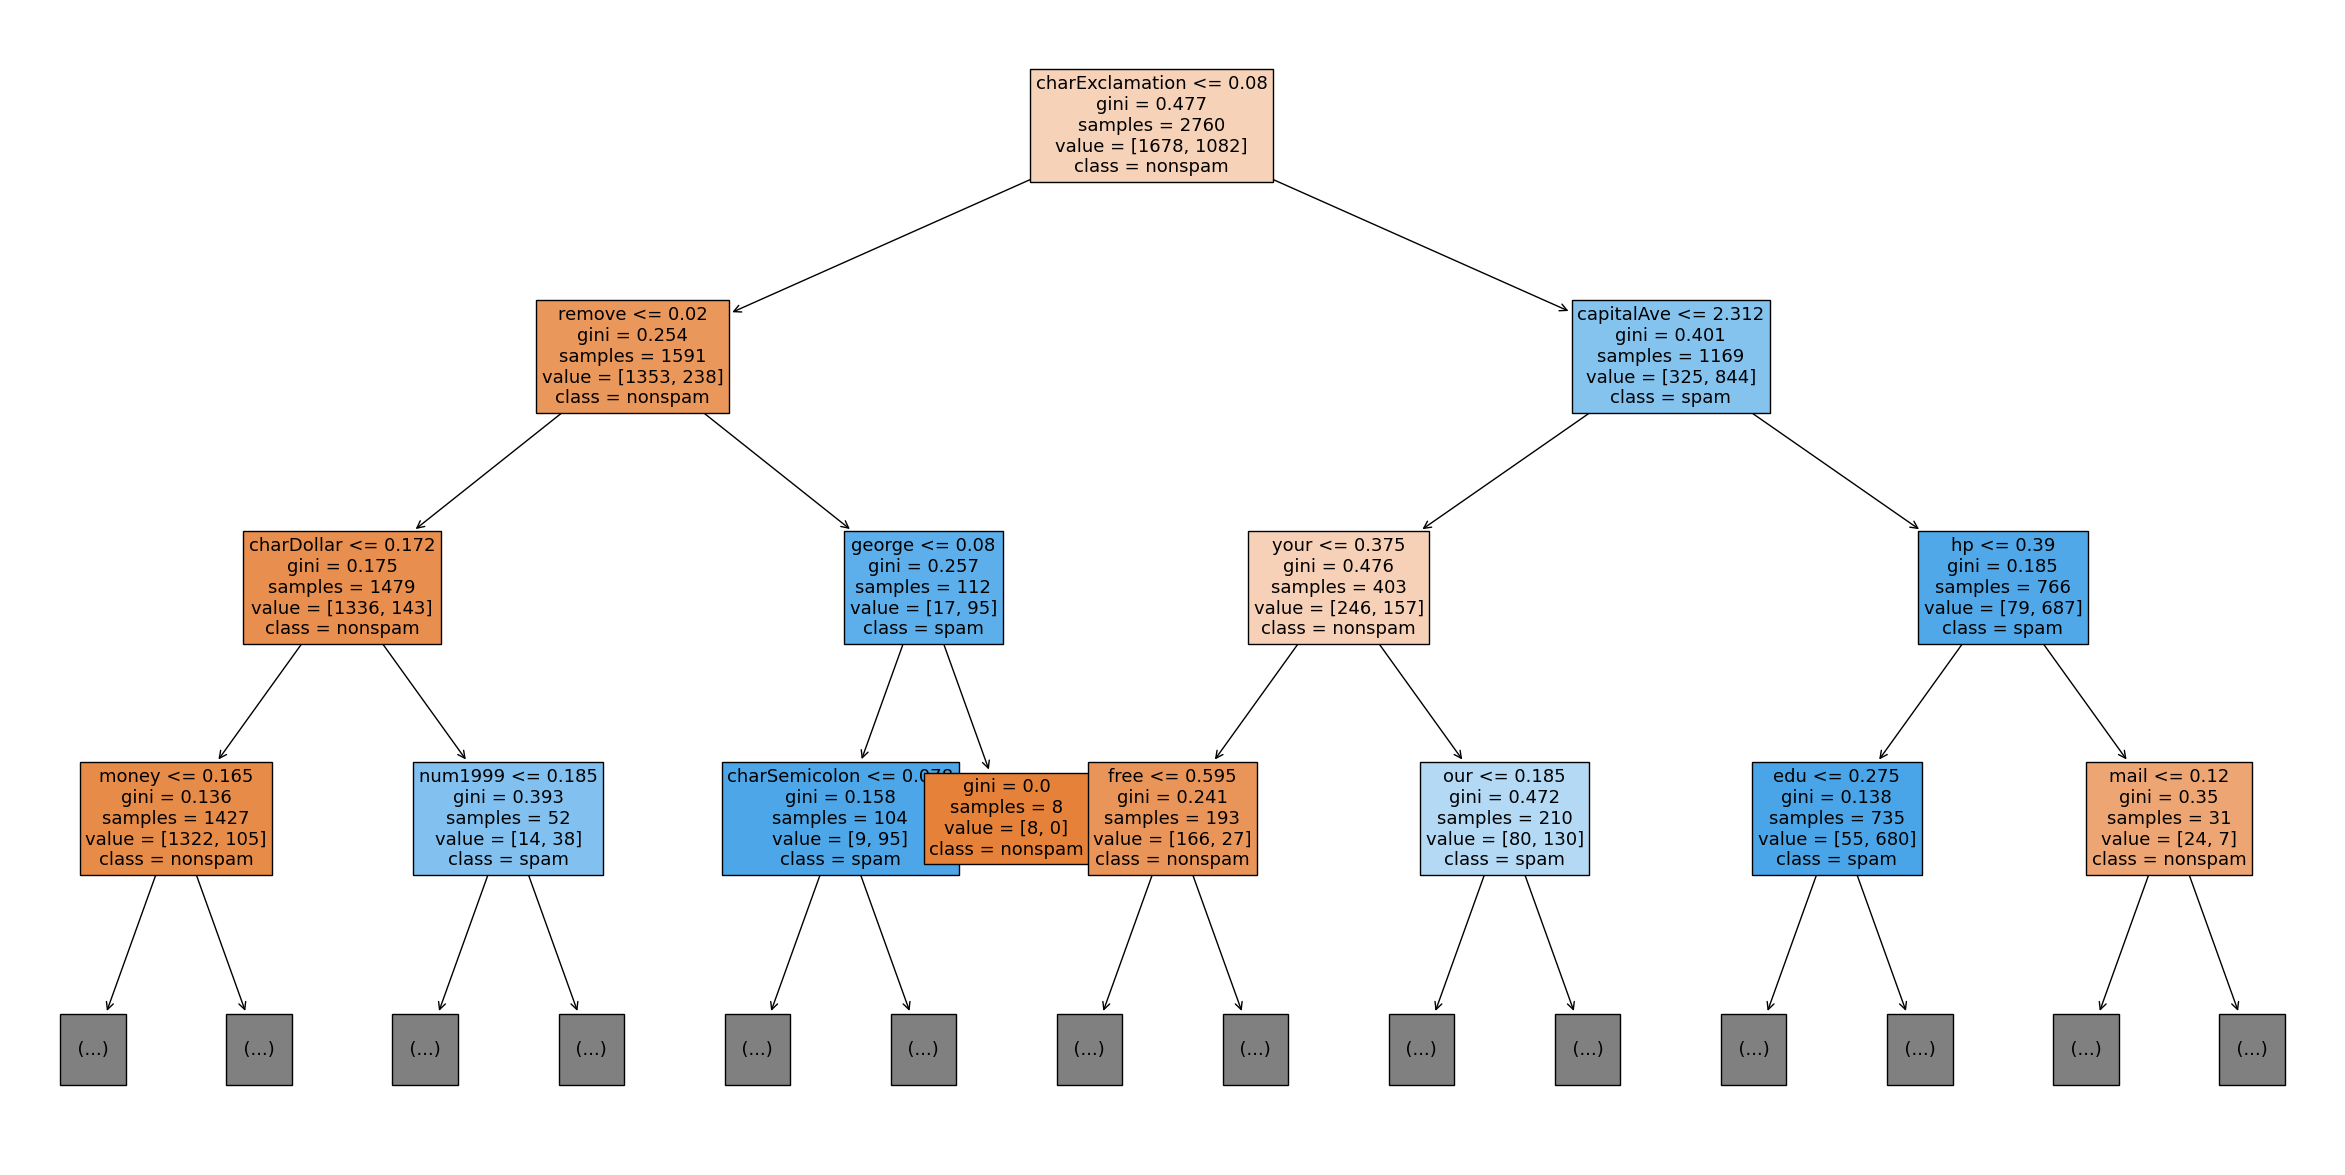

In [4]:
# | label: 2-b-2
# train on random 60% splits

for random_state in [42, 321]:
    X_train, X_test, y_train, y_test = train_test_split(
        X_spam, y_spam, train_size=0.6, random_state=random_state
    )
    tree_class_sub1 = DecisionTreeClassifier()
    tree_class_sub1.fit(X_train, y_train)
    # use plot_tree to visualize the decision tree
    plt.figure(figsize=(30, 15))
    plot_tree(
        tree_class_sub1,
        max_depth=3,
        feature_names=X_train.columns,
        class_names=class_names,
        filled=True,
        fontsize=13,
    )
    plt.show()

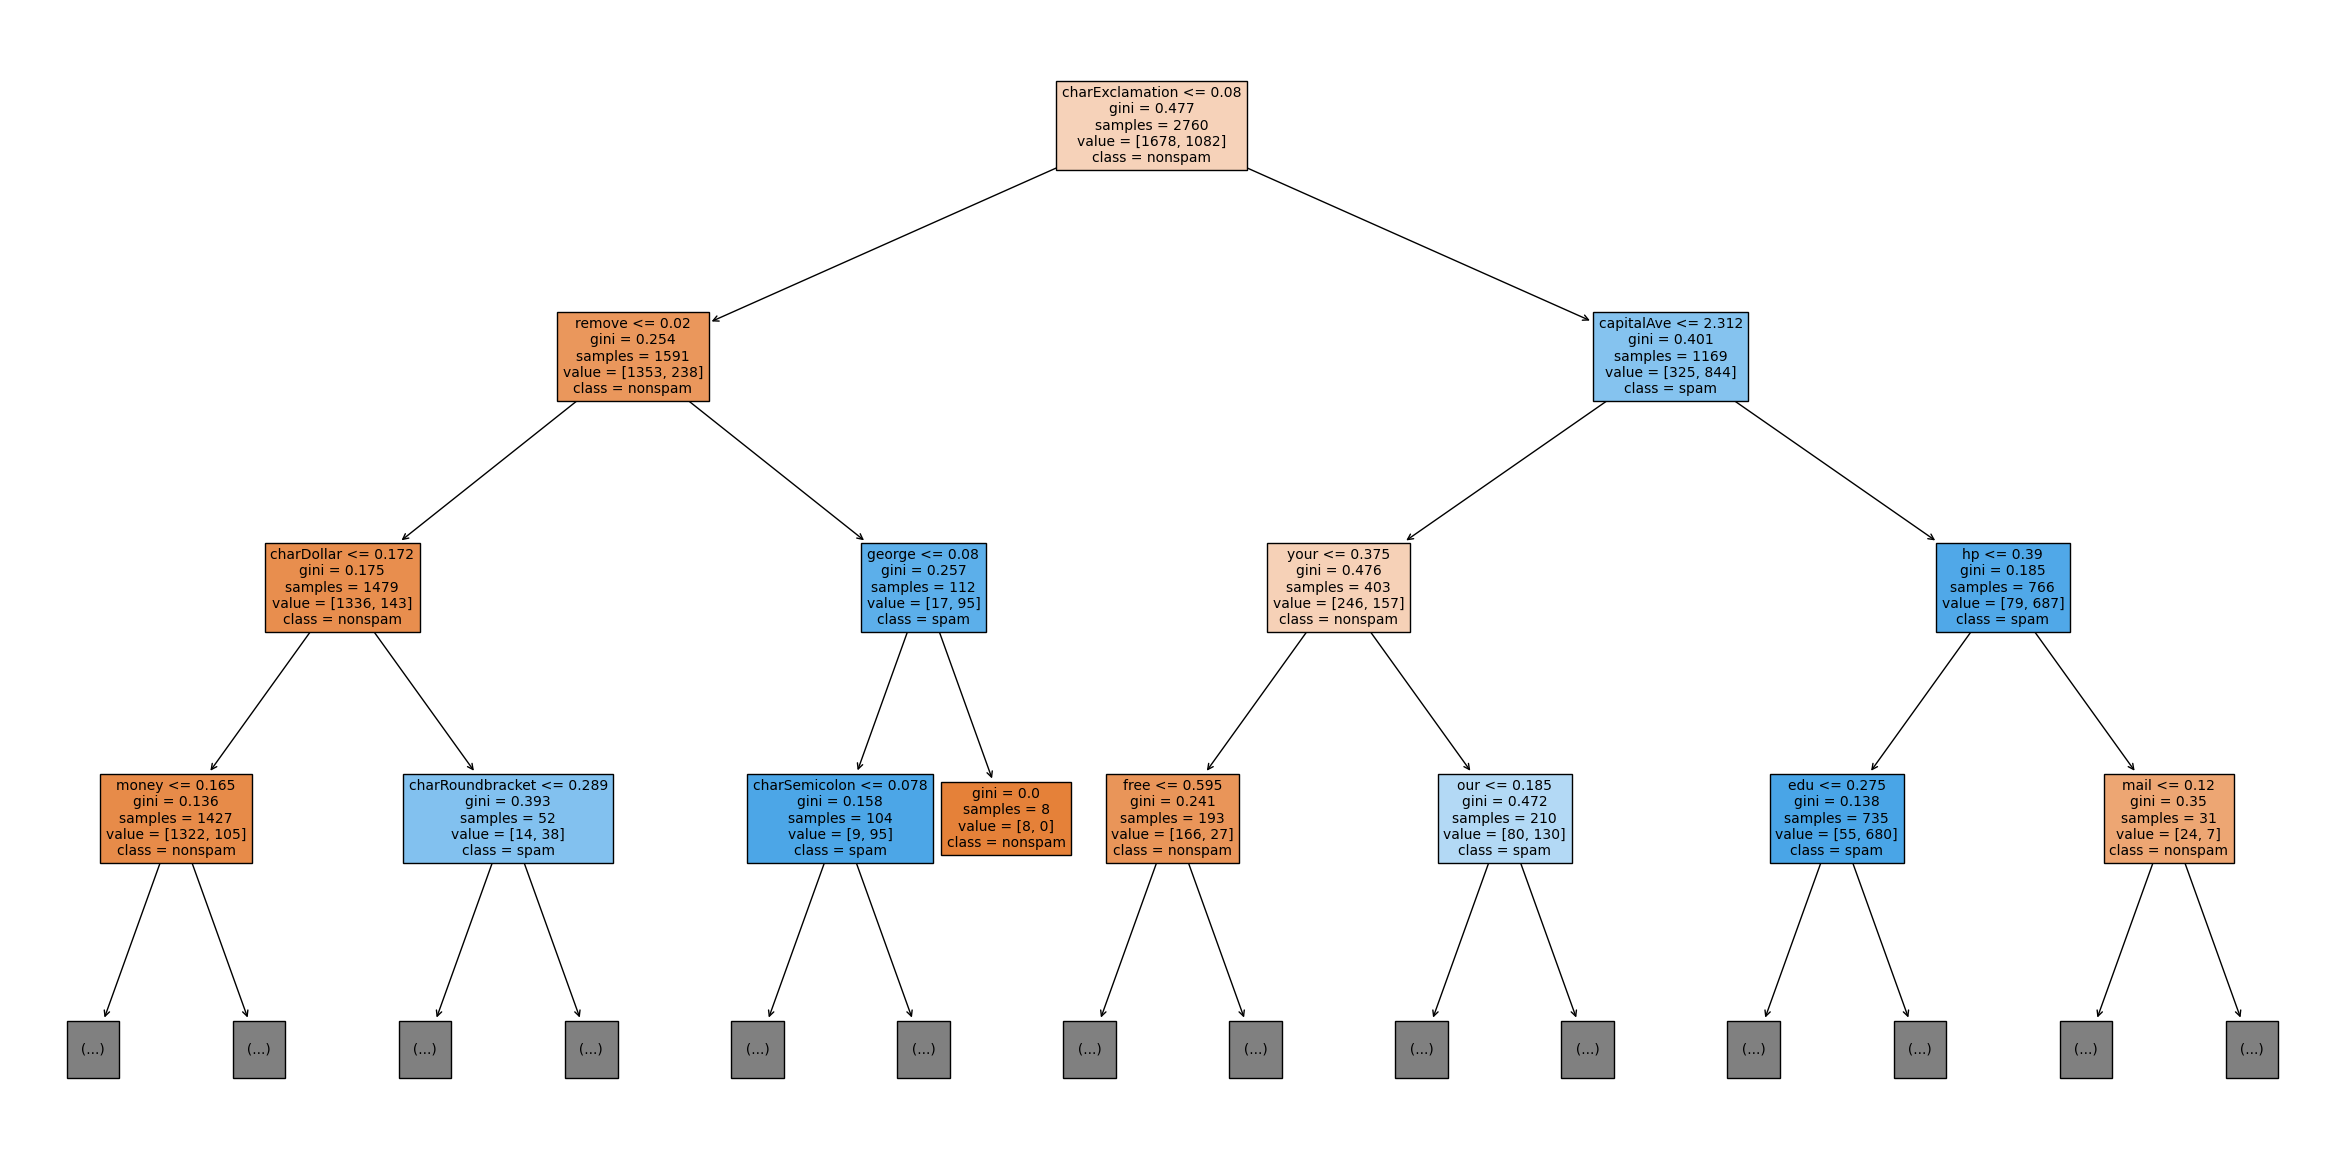

In [22]:
# | label: 2-b-3
# train on second random 60% split
random_state = 321
X_train, X_test, y_train, y_test = train_test_split(
    X_spam, y_spam, train_size=0.6, random_state=random_state
)

tree_class_sub2 = DecisionTreeClassifier()
tree_class_sub2.fit(X_train, y_train)
# use plot_tree to visualize the decision tree
plt.figure(figsize=(30, 15))
plot_tree(
    tree_class_sub2,
    max_depth=3,
    feature_names=X_train.columns,
    class_names=class_names,
    filled=True,
    fontsize=10,
)
plt.show()

Observation: trees trained on different samples differ considerably in their structure, regarding split variables as well as thresholds (recall, though, that the split candidates are a further source of randomness).

### c)

### i)

This is actually quite easy when we recall that the exponential 
    function at an arbitrary input $x$ can be characterized via
    $$e^x = \lim_{n \to \infty} \left( 1 + \tfrac{x}{n} \right)^n, $$
    which already resembles the limit expression we are looking 
    for. 
    Setting $x$ to -1 yields:
    $$\lim_{n \to \infty} \left( 1 - \tfrac{1}{n} \right)^n = e^{-1} = 
    \tfrac{1}{e}.$$

### ii)

In [23]:
# | label: 2-c
crf_full = RandomForestClassifier(random_state=43, oob_score=True)
crf_full.fit(X_spam, y_spam)

print("OOB-error: ", 1 - crf_full.oob_score_)

OOB-error:  0.04564225168441638


### d)

Variable importance in general measures the contributions of features to a model.
The Random Forest class in sklearn can use two built-in feature importance methods:
- Gini importance (or mean decrease impurity): computed from the Random Forest structure
- Mean Decrease Accuracy: computed for permutated features on a hold-out set

The default in sklearn is the feature importance based on Gini Impurity, callable by crf.feature_importances_.
It is worth to mention that in this method we should look at relative values of the computed importance.
The biggest advantage of this method is a speed of computation - all needed values are computed during the Random Forest training.
The drawbacks of the method are the tendency to prefer (select as important) numerical features and categorical features with high cardinality.
Furthermore, in the case of correlated features it can select one of the features and neglect the importance of the second one (which can lead to wrong conclusions).
 
The permutation-based importance can be used to overcome drawbacks of default feature importance computed with mean impurity decrease.
It is implemented in scikit-learn as the permutation_importance method. It can be seen as a generalized version of the OOB permutation feature importance, which is very specific for feature importance of a Random Forests. <br> 
The OOB permutation importance of the j-th variable is based on permuting it for the OOB observations and calculating
the mean increase in OOB error this permutation entails. Nevertheless, this is not implemented in sklearn.<br>
The function permutation_importance requires a trained model (can be any model compatible with scikit-learn API)
and validation, resp. test data as arguments. This method will randomly shuffle each feature and compute the change in the model’s performance on the hold-out set.
The features which impact the performance the most are the most important ones.

In order to determine the features with the biggest influence on prediction quality, we can choose the k variables with
the highest importance score, e.g., for k = 5:

In [24]:
# | label: 2-d-1
random_state = 321
k = 5
# create a hold-out set and fit another Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(
    X_spam, y_spam, test_size=0.25, random_state=random_state
)
crf_perm = RandomForestClassifier(random_state=random_state)
crf_perm.fit(X_train, y_train)

result = permutation_importance(crf_perm, X_test, y_test, random_state=random_state)
forest_importances = pd.Series(result.importances_mean, index=X_test.columns)
sorted_idx = forest_importances.argsort()
sorted_idx = sorted_idx[::-1]  # reverse order
sorted_idx_selected = sorted_idx[:k]

print(forest_importances[sorted_idx_selected])

remove             0.021025
hp                 0.017376
charExclamation    0.016334
george             0.009731
capitalLong        0.009209
dtype: float64


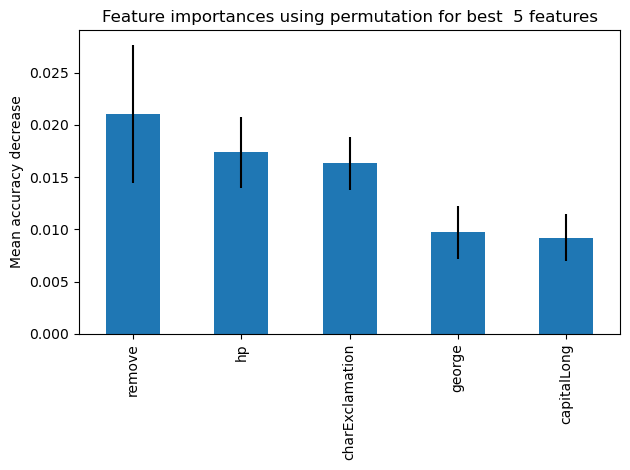

In [25]:
# | label: 2-d-2
fig, ax = plt.subplots()
forest_importances[sorted_idx_selected].plot.bar(
    yerr=result.importances_std[sorted_idx_selected], ax=ax
)
ax.set_title("Feature importances using permutation for best %2d features" % k)
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Solution 3: Proximities

### Extra: Computing leaf indices in Python

In [26]:
wine_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data",
    header=None,
)
wine_data = wine_data.iloc[:, [0, 4, 1, 7, 11, 2, 6]]
wine_data.columns = [
    "type",
    "alcalinity",
    "alcohol",
    "flavanoids",
    "hue",
    "malic",
    "phenols",
]
wine_data_sub = wine_data.iloc[[13, 169, 49], :]

wine_data_sub.head()

,type,alcalinity,alcohol,flavanoids,hue,malic,phenols
13,1,11.4,14.75,3.69,1.25,1.73,3.10
169,3,25.0,13.40,0.96,0.67,4.60,1.98
49,1,17.4,13.94,3.54,1.12,1.73,2.88


In [27]:
X_wine = wine_data.copy()  # note without copy X_wine is not a variable but a pointer
y_wine = X_wine.pop("type")
X_wine_sub = wine_data_sub.copy()
y_wine_sub = X_wine_sub.pop("type")

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=3, max_depth=2, random_state=14)
rf.fit(X_wine, y_wine)

leaf_indices = rf.apply(X_wine_sub)
print(leaf_indices)

[[6 4 5]
 [6 1 6]
 [6 4 5]]


Using the rf.apply(X_wine_sub) output, we can follow the path of each sample through each tree.

### a)

The following table prints for each observation (rows) their terminal nodes as assigned by trees 1-3. For example,
consider observation 1 in tree 1 (first cell): the observation has phenols > 1.94, putting it in node 2 (rightChild
of node 0), from there in node 6 (because it has alcohol > 13.04).

In [28]:
# | label: 3-a
end_nodes = pd.DataFrame(
    {"tree_1": [6, 6, 6], "tree_2": [6, 5, 6], "tree_3": [6, 5, 6]}
)
print(end_nodes)

   tree_1  tree_2  tree_3
0       6       6       6
1       6       5       5
2       6       6       6


### b)

For the proximities, we consider each pair of observations and compute the relative frequency of trees assigning
them to the same terminal node.
- Observations 1 and 2: only tree 1 assigns them to the same node, so the proximity is $\tfrac{1}{3}$.
- Observations 1 and 3: all trees assign them to the same node, so the proximity is 1.
- Observations 2 and 3: only tree 1 assigns them to the same node, so the proximity is $\tfrac{1}{3}$.

### c)

We can put this information into a similarity matrix (as such matrices become large quite quickly for more
data, it is common to store only the lower diagonal – the rest is non-informative/redundant):

In [29]:
# | label: 3-c-1
# Compute the pairwise distances between the rows of X
distances = 1 - pdist(end_nodes, metric="hamming")
# Compute the size of the matrix
n = end_nodes.shape[0]
size = (n * (n - 1)) // 2
# Create a sparse matrix to store the pairwise distances.
# Sparse matrices only need memory space for values unequal to zero.
distance_matrix = dok_matrix((n, n), dtype=np.float32)
# Populate the lower triangle of the matrix with the distances
i, j = np.tril_indices(n, k=-1)
distance_matrix[i, j] = distances[:size]
# Print the matrix
print(distance_matrix.toarray())

[[0.         0.         0.        ]
 [0.33333334 0.         0.        ]
 [1.         0.33333334 0.        ]]
